In [1]:
import weave
assert weave.__version__ >= "0.50.14", "Please upgrade weave!" 
from weave.trace.env import _wandb_api_key_via_netrc

from tqdm import tqdm
from collections import defaultdict

import pandas as pd

import altair as alt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

import multiprocessing
from multiprocessing.pool import ThreadPool
import subprocess
import tempfile
import sys

import requests
from requests.auth import HTTPBasicAuth
import json

selected_metrics = ["StrLenScorer", "KolmogorovComplexity", "KolmogorovComplexityNormalized", "MissingTopicScorer", "FleshReadingScorer", "TopicConsistency", "NamedEntityDensity", "GoldenDescriptionROUGEScorer", 'GoldenDescriptionCosineTFIDFScorer', 'GoldenDescriptionBLEUScorer']

# Define weave project ID and initialize weave client
project_id = "highly-biased/temp_05_reeval"

client = weave.init(project_id)
calls = client.server.calls_query_stream({
   "project_id": project_id,
   "filter": {"trace_roots_only": True},
   "sort_by": [{"field":"started_at","direction":"desc"}],
})
calls = client.get_calls(
    filter={"call_ids":[call.id for call in calls]},
)
calls = list(calls)

weave version 0.51.46 is available!  To upgrade, please run:
 $ pip install weave --upgrade
Logged in as Weights & Biases user: dominik-karasin.
View Weave data at https://wandb.ai/highly-biased/temp_05_reeval/weave


In [2]:
# Create user prompts lookup mappings  

dataset = weave.ref("set1_test:v0").get()

dataset_lookup_map = dict()
for row in dataset.rows:
    id = row.ref._extra[-1]
    user_prompt = row["user_prompt"]
    dataset_lookup_map[id] = user_prompt


Expected length of response rows (100) to match prefetched rows (720). Ignoring prefetched rows.


In [3]:
# Load data from weave

outputs = defaultdict(list)
counts = defaultdict(lambda: 0)
user_prompts = defaultdict(list)
ids = defaultdict(list)

for call in tqdm(calls):
    model_name = call.inputs["model"].model_name

    call_id = call.id

    payload = {
        "project_id":project_id,
        "filter":{"parent_ids":[call_id],"trace_roots_only":False},
        "limit":3000,
        "offset":0,
        "sort_by":[{"field":"started_at","direction":"desc"}],
        "include_feedback": False,
        "expand_columns":["inputs.example.user_prompt"]
    }

    response = requests.request("POST","https://trace.wandb.ai/calls/stream_query", 
                                headers={
                                    'Content-Type': 'application/json',
                                    'Accept': 'application/json'
                                    }, 
                                data=json.dumps(payload),
                                auth=HTTPBasicAuth("api", _wandb_api_key_via_netrc()))

    counts[model_name]+=call.inputs["self"].trials

    scores = []
    for child in tqdm(response.json(), leave=False):
        if 'Evaluation.summarize' in child["op_name"]:
            continue

        ids[model_name].append(child["id"])
        
        user_prompt_id = child["inputs"]["example"].rsplit("/", 1)[-1]
        user_prompts[model_name].append(dataset_lookup_map[user_prompt_id].split(", "))

        if child["output"] is not None:
            child_scorers = {}
            for k, v in child["output"]['scores'].items():
                if k in selected_metrics:
                    child_scorers[k] = v
            scores.append(child_scorers)
    
    outputs[model_name] += scores

100%|██████████| 12/12 [07:19<00:00, 36.59s/it]


In [4]:
# Define model and metric replacement names for better readability and consistency

model_name_replacements = {
    'Llama3.2': "LLaMA 3.2 3B",
    'gemma2:27b': "Gemma 2 27B",
    'wizardlm2': "WizardLM-2",
    'Llama3.2:1B': "LLaMA 3.2 1B",
    'gemma2:2b': "Gemma 2 2B",
    'gemini-2.0-flash-001': "Gemini 2.0 Flash",
    'gemini-1.5-flash-8b-001': "Gemini 1.5 Flash-8B",
    'mistral': "Mistral",
    'gemini-1.5-flash-002': "Gemini 1.5 Flash",
    'solar': "Solar",
    'gpt-3.5-turbo-0125': "GPT-3.5 Turbo",
    'gpt-4o-mini-2024-07-18': "GPT-4o mini",
    'gpt-4o-2024-11-20': "GPT-4o"
}

metric_name_replacements = {
    "GoldenDescriptionROUGEScorer": "Golden Description ROUGE", 
    'GoldenDescriptionCosineTFIDFScorer': "Golden Description TF-IDF", 
    'GoldenDescriptionBLEUScorer': "Golden Description BLEU",
    "FleshReadingScorer": "FRE", 
    "KolmogorovComplexityNormalized": "KC CompressionRatio", 
    "KolmogorovComplexity": "KC", 
    "MissingTopicScorer": "MissingTopics",
    "StrLenScorer": "StringLength",
    'rouge1': "Golden Description ROUGE 1",
    'rouge2': "Golden Description ROUGE 2",
    'rougeL': "Golden Description ROUGE L",
    'rougeLsum': "Golden Description ROUGE sum",
    'stemmed': "Golden Description TF-IDF stemmed",
    'lemmatized': "Golden Description TF-IDF lemmatized",
    'bleu': "Golden Description BLEU",
    'brevity_penalty': "Golden Description BLEU brevity penalty",
    'length_ratio': "Golden Description BLEU length ratio",
    'translation_length': "Golden Description BLEU translation length",
    'reference_length': "Golden Description BLEU reference length",
    'precisions_1': "Golden Description BLEU precision 1",
    'precisions_2': "Golden Description BLEU precision 2",
    'precisions_3': "Golden Description BLEU precision 3",
    'precisions_4': "Golden Description BLEU precision 4",
}   

In [5]:
# Processes loaded data, extract metric scores, positions, topics, and prompts 

results = {}

for model, data in tqdm(outputs.items()):

    results_per_model = defaultdict(list)

    prompts = user_prompts[model]
    ids_per_model = ids[model]

    if model in model_name_replacements:
        model = model_name_replacements[model]

    model = model.replace(":", "-")

    for metrics, prompt, id in zip(data, prompts, ids_per_model, strict=True):
        for metric in metrics.keys():

            if any("_" in key for key in metrics[metric]):
                for key in metrics[metric].keys():
                    pos, submetric = key.split("_", maxsplit=1)

                    if not pos.isdigit():
                        continue

                    res = {}
                    res["metric"] = metric_name_replacements[submetric] if submetric in metric_name_replacements else submetric
                    res["position"] = int(pos) + 1
                    res["score"] = metrics[metric][pos + "_" + submetric]
                    topic = next(key for key, val in metrics[metric].items() if val == res["score"] and not key[0].isdigit())
                    res["topic"] = topic.split("_")[0]
                    res["prompt"] = prompt
                    res["id"] = id
                    results_per_model[metric_name_replacements[submetric] if submetric in metric_name_replacements else submetric].append(res)

            
            else:
                for pos in range(0, 6):
                    if str(pos) not in list(metrics[metric].keys()) or metrics[metric][str(pos)] is None:
                        continue

                    res = {}
                    res["metric"] = metric_name_replacements[metric] if metric in metric_name_replacements else metric
                    res["position"] = pos + 1
                    res["score"] = metrics[metric][str(pos)]
                    res["topic"] = next(key for key, val in metrics[metric].items() if val == res["score"] and not key.isdigit())
                    res["prompt"] = prompt
                    res["id"] = id
                    results_per_model[metric_name_replacements[metric] if metric in metric_name_replacements else metric].append(res)

    results[model] = results_per_model

100%|██████████| 12/12 [00:12<00:00,  1.08s/it]


In [6]:
# Gather max/min scores for each metric

axes_max_values = defaultdict(lambda: float("-inf"))
axes_min_values = defaultdict(lambda: float("inf"))

for model, model_data in tqdm(results.items()):
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        axes_max_values[metric] = max(axes_max_values[metric], df["score"].max())
        axes_min_values[metric] = min(axes_min_values[metric], df["score"].min())

100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


In [7]:
# Generate boxplots displaying the distributions per position

save_dir = r"plots_0.5/boxplots/per_position"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in tqdm(results.items()):
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        plt.figure(figsize=(10, 2.5))
        plt.clf()
        ax = sns.boxplot(data=df, x='position', y='score', 
                        color='white',width=0.3,dodge=True, whis=(1,99.8),flierprops={"marker": ".",'markersize':1.5})

        sns.stripplot(data=df, x='position', y='score', hue='topic', alpha=0.7, jitter=True, size=1)

        _ = plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=6, 
                fontsize=8, frameon=False, markerscale=5)
        
        plt.title(f"{model}-{metric}")

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

100%|██████████| 12/12 [02:22<00:00, 11.89s/it]


In [8]:
# Generate boxplots displaying the distributions per position, with fixed axis

save_dir = r"plots_0.5/boxplots/per_position_axis_fixed"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in tqdm(results.items()):
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        plt.figure(figsize=(10, 2.5))
        plt.clf()
        ax = sns.boxplot(data=df, x='position', y='score', 
                        color='white',width=0.3,dodge=True, whis=(1,99.8),flierprops={"marker": ".",'markersize':1.5})

        sns.stripplot(data=df, x='position', y='score', hue='topic', alpha=0.7, jitter=True, size=1)

        _ = plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=6, 
                fontsize=8, frameon=False, markerscale=5)
        
        plt.title(f"{model}-{metric}") 

        plt.ylim(axes_min_values[metric], axes_max_values[metric])

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

100%|██████████| 12/12 [02:17<00:00, 11.46s/it]


In [9]:
# Generate boxplots displaying the distributions per topic

save_dir = r"plots_0.5/boxplots/per_topic"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in tqdm(results.items()):
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        plt.figure(figsize=(10, 2.5))
        plt.clf()
        ax = sns.boxplot(data=df, x='topic', y='score', 
                        color='white',width=0.3,dodge=True, whis=(1,99.8),flierprops={"marker": ".",'markersize':1.5})

        sns.stripplot(data=df, x='topic', y='score', hue='position', alpha=0.7, jitter=True, size=1, palette="pastel")

        _ = plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', 
                fontsize=8, frameon=False, markerscale=5)
        
        plt.title(f"{model}-{metric}")

        plt.xticks(rotation = 90)

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

100%|██████████| 12/12 [03:06<00:00, 15.50s/it]


In [10]:
# Generate boxplots displaying the distributions per topic, with a fixed axis

save_dir = r"plots_0.5/boxplots/per_topic_axis_fixed"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in tqdm(results.items()):
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        plt.figure(figsize=(10, 2.5))
        plt.clf()
        ax = sns.boxplot(data=df, x='topic', y='score', 
                        color='white',width=0.3,dodge=True, whis=(1,99.8),flierprops={"marker": ".",'markersize':1.5})

        sns.stripplot(data=df, x='topic', y='score', hue='position', alpha=0.7, jitter=True, size=1, palette="pastel")

        _ = plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', 
                fontsize=8, frameon=False, markerscale=5)
        
        plt.title(f"{model}-{metric}")

        plt.xticks(rotation = 90)

        plt.ylim(axes_min_values[metric], axes_max_values[metric])

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

100%|██████████| 12/12 [02:55<00:00, 14.62s/it]


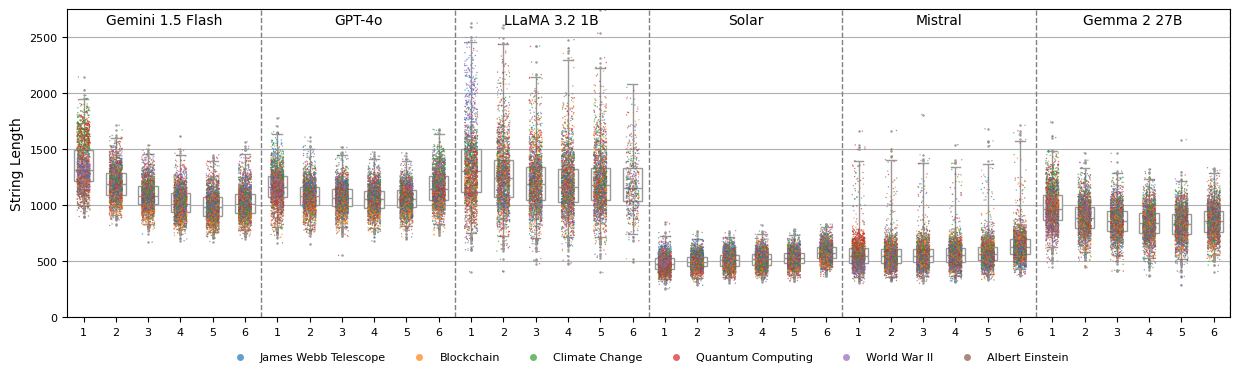

In [11]:
# Join boxplot for metric StringLength and selected models

joined_boxplot_metric = "StringLength"
joined_boxplot_models = ["Gemini 1.5 Flash", "GPT-4o", "LLaMA 3.2 1B", "Solar", "Mistral", "Gemma 2 27B"]

plot_data = []
for model in joined_boxplot_models:
    if model in results:
        model_data = results[model]
        if joined_boxplot_metric in model_data:
            df = pd.DataFrame(model_data[joined_boxplot_metric])
            df["Model"] = model
            plot_data.append(df)


combined_df = pd.concat(plot_data, ignore_index=True)

position_values = sorted(combined_df["position"].unique())

combined_df["x_position"] = combined_df["position"].astype(str) + combined_df["Model"]

plt.figure(figsize=(2.5 * len(joined_boxplot_models), 4))

ax = sns.boxplot(data=combined_df, x='x_position', y='score', 
                 color='white', width=0.6, dodge=True, 
                 whis=(1, 99.8), flierprops={"marker": ".", 'markersize': 1.5})


sns.stripplot(data=combined_df, x='x_position', y='score', hue='topic', 
              alpha=0.7, jitter=0.2, size=1, dodge=False)

xtick_positions = []
xtick_labels = []
for i in range(0, len(joined_boxplot_models) * 6, 6):
    for pos in position_values:
        mid_x = pos + i - 1
        xtick_positions.append(mid_x)
        xtick_labels.append(pos)

plt.xticks(xtick_positions, xtick_labels)

for i in range(1, len(joined_boxplot_models) + 1):
    plt.axvline(x=len(position_values) * i - 0.5, color="gray", linestyle="--", linewidth=1)


    plt.text(1 / (len(joined_boxplot_models) * 2) + ((i-1) * 1 / (len(joined_boxplot_models) * 2) * 2), 0.95, joined_boxplot_models[i - 1], 
                horizontalalignment="center", fontsize=10, transform=plt.gca().transAxes)


plt.legend(title="", loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=8, frameon=False,
            markerscale=5)

ax.grid(axis='y' )

ax.tick_params(axis='both', labelsize=8)

plt.ylim(0, 2750)

plt.xlabel("")
plt.ylabel("String Length", fontsize=10)

plt.show()


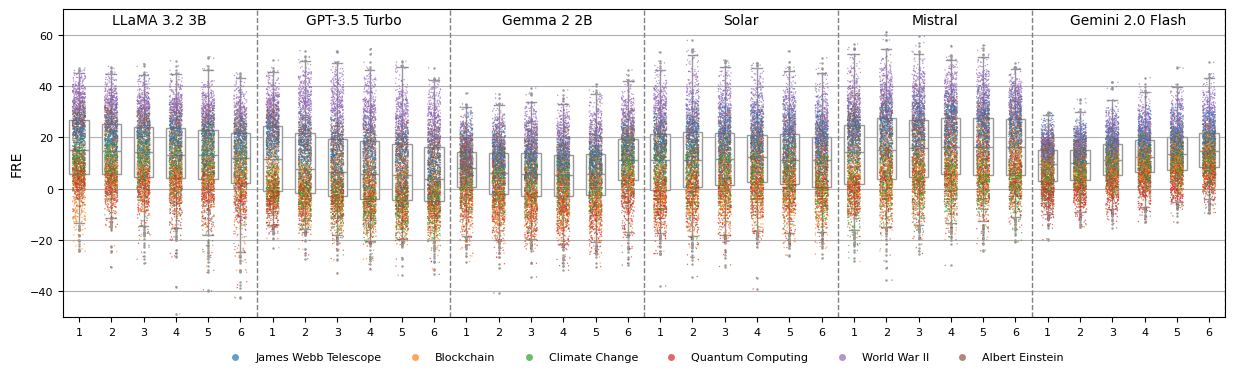

In [12]:
# Join boxplot for metric FRE and selected models

joined_boxplot_metric = "FRE"
joined_boxplot_models = ["LLaMA 3.2 3B", "GPT-3.5 Turbo", "Gemma 2 2B", "Solar", "Mistral", "Gemini 2.0 Flash"]

plot_data = []
for model in joined_boxplot_models:
    if model in results:
        model_data = results[model]
        if joined_boxplot_metric in model_data:
            df = pd.DataFrame(model_data[joined_boxplot_metric])
            df["Model"] = model
            plot_data.append(df)


combined_df = pd.concat(plot_data, ignore_index=True)

position_values = sorted(combined_df["position"].unique())

combined_df["x_position"] = combined_df["position"].astype(str) + combined_df["Model"]

plt.figure(figsize=(2.5 * len(joined_boxplot_models), 4))

ax = sns.boxplot(data=combined_df, x='x_position', y='score', 
                 color='white', width=0.6, dodge=True, 
                 whis=(1, 99.8), flierprops={"marker": ".", 'markersize': 1.5})


sns.stripplot(data=combined_df, x='x_position', y='score', hue='topic', 
              alpha=0.7, jitter=0.2, size=1, dodge=False)

xtick_positions = []
xtick_labels = []
for i in range(0, len(joined_boxplot_models) * 6, 6):
    for pos in position_values:
        mid_x = pos + i - 1
        xtick_positions.append(mid_x)
        xtick_labels.append(pos)

plt.xticks(xtick_positions, xtick_labels)

for i in range(1, len(joined_boxplot_models) + 1):
    plt.axvline(x=len(position_values) * i - 0.5, color="gray", linestyle="--", linewidth=1)


    plt.text(1 / (len(joined_boxplot_models) * 2) + ((i-1) * 1 / (len(joined_boxplot_models) * 2) * 2), 0.95, joined_boxplot_models[i - 1], 
                horizontalalignment="center", fontsize=10, transform=plt.gca().transAxes)


plt.legend(title="", loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=8, frameon=False,
            markerscale=5)

ax.grid(axis='y' )

ax.tick_params(axis='both', labelsize=8)

plt.ylim(-50, 70)

plt.xlabel("")
plt.ylabel("FRE", fontsize=10)

plt.show()


In [13]:
# Create joined boxplots per position

save_dir = r"plots_0.5/boxplots/joined_boxplots_per_position"

metrics = results["GPT-4o"].keys()

os.makedirs(save_dir, exist_ok=True)

joined_boxplot_models_A = ["LLaMA 3.2 3B", "GPT-3.5 Turbo", "Gemma 2 2B", "Solar", "Mistral", "Gemini 2.0 Flash"]
joined_boxplot_models_B = ["Gemini 1.5 Flash", "GPT-4o", "LLaMA 3.2 1B", "Solar", "Mistral", "Gemma 2 27B"]

for models in [joined_boxplot_models_A, joined_boxplot_models_B]:
    for metric in metrics:
        plot_data = []
        for model in models:
            model_data = results[model]
            df = pd.DataFrame(model_data[metric])
            df["Model"] = model
            plot_data.append(df)


        combined_df = pd.concat(plot_data, ignore_index=True)

        position_values = sorted(combined_df["position"].unique())

        combined_df["x_position"] = combined_df["position"].astype(str) + combined_df["Model"]

        plt.figure(figsize=(2.5 * len(models), 4))

        ax = sns.boxplot(data=combined_df, x='x_position', y='score', 
                        color='white', width=0.6, dodge=True, 
                        whis=(1, 99.8), flierprops={"marker": ".", 'markersize': 1.5})


        sns.stripplot(data=combined_df, x='x_position', y='score', hue='topic', 
                    alpha=0.7, jitter=0.2, size=1, dodge=False)

        xtick_positions = []
        xtick_labels = []
        for i in range(0, len(models) * 6, 6):
            for pos in position_values:
                mid_x = pos + i - 1
                xtick_positions.append(mid_x)
                xtick_labels.append(pos)

        plt.xticks(xtick_positions, xtick_labels)

        for i in range(1, len(models) + 1):
            plt.axvline(x=len(position_values) * i - 0.5, color="gray", linestyle="--", linewidth=1)


            plt.text(1 / (len(models) * 2) + ((i-1) * 1 / (len(models) * 2) * 2), 0.95, models[i - 1], 
                        horizontalalignment="center", fontsize=10, transform=plt.gca().transAxes)


        plt.legend(title="", loc="lower center", bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=8, frameon=False,
                    markerscale=5)

        ax.grid(axis='y' )

        ax.tick_params(axis='both', labelsize=8)


        plt.xlabel("")
        plt.ylabel(f"{metric}", fontsize=10)

        plt.savefig(f'{save_dir}/{metric}_{", ".join(models)}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

In [14]:
# Create joined boxplots per topic

save_dir = r"plots_0.5/boxplots/joined_boxplots_per_topic"

os.makedirs(save_dir, exist_ok=True)

joined_boxplot_metrics = ["FRE", "KC CompressionRatio", "StringLength", "NamedEntityDensity", "Golden Description TF-IDF lemmatized", "Golden Description ROUGE sum", "Golden Description BLEU"]

joined_boxplot_models_A = ["LLaMA 3.2 3B", "GPT-3.5 Turbo", "Gemma 2 2B", "Solar", "Mistral", "Gemini 2.0 Flash"]
joined_boxplot_models_B = ["Gemini 1.5 Flash", "GPT-4o", "LLaMA 3.2 1B", "Solar", "Mistral", "Gemma 2 27B"]

for models in [joined_boxplot_models_A, joined_boxplot_models_B]:
    for metric in joined_boxplot_metrics:
        plot_data = []
        for model in models:
            model_data = results[model]
            df = pd.DataFrame(model_data[metric])
            df["Model"] = model
            plot_data.append(df)

        combined_df = pd.concat(plot_data, ignore_index=True)

        topic_values = sorted(combined_df["topic"].unique())

        combined_df["x_topic"] = combined_df["topic"].astype(str) + combined_df["Model"]

        plt.figure(figsize=(2.5 * len(models), 4))

        ax = sns.boxplot(data=combined_df, x='x_topic', y='score', 
                        color='white', width=0.6, dodge=True, 
                        whis=(1, 99.8), flierprops={"marker": ".", 'markersize': 1.5})


        sns.stripplot(data=combined_df, x='x_topic', y='score', hue='position', 
                    alpha=0.7, jitter=0.2, size=1, dodge=False, palette="pastel")

        xtick_positions = []
        xtick_labels = []
        for i in range(0, len(models) * 6, 6):
            for pos in range(len(topic_values)):
                mid_x = pos + i - 1
                xtick_positions.append(mid_x)
                xtick_labels.append(topic_values[pos - 1])

        plt.xticks(xtick_positions, xtick_labels)

        for i in range(1, len(models) + 1):
            plt.axvline(x=len(topic_values) * i - 0.5, color="gray", linestyle="--", linewidth=1)


            plt.text(1 / (len(models) * 2) + ((i-1) * 1 / (len(models) * 2) * 2), 0.95, models[i - 1], 
                        horizontalalignment="center", fontsize=10, transform=plt.gca().transAxes)


        plt.legend(title="", loc="center", bbox_to_anchor=(1.02, 0.5),  fontsize=8, frameon=False,
                    markerscale=5)

        ax.grid(axis='y' )

        ax.tick_params(axis='both', labelsize=8)


        plt.xlabel("")
        plt.ylabel(f"{metric}", fontsize=10)

        plt.xticks(rotation = 90)

        plt.savefig(f'{save_dir}/{metric}_{", ".join(models)}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

In [15]:
# Create swarmplots per position with fixed axis

save_dir = r"plots_0.5/swarmplots/per_position_axis_fixed"

total = 0
for metric_data in results.values():
    total += len(metric_data)

pbar = tqdm(total=total)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def start_subprocess(tmp_file_path):
    p = subprocess.Popen([sys.executable, 'helper/create_swarmplot.py', tmp_file_path, str(True)])
    p.wait()
    pbar.update(1)


with ThreadPool(processes=multiprocessing.cpu_count()) as pool:
    try:
        tmp_files = []
        for model, model_data in results.items():
            for metric, metric_data in model_data.items():
                if metric == "MissingTopics":
                    continue
                
                tmp = tempfile.NamedTemporaryFile(delete=False, mode="w+")
                json.dump({"model":model,
                            "metric":metric,
                            "metric_data":metric_data,
                            "axes_min":axes_min_values[metric].item(), 
                            "axes_max":axes_max_values[metric].item(),
                            "save_dir":save_dir}, tmp)
                tmp.flush()
                tmp_files.append(tmp.name)
                tmp.close()
                
        result = pool.map_async(start_subprocess, tmp_files)
        result.wait()
    finally: 
        pbar.close()

 95%|█████████▌| 252/264 [34:13<01:37,  8.15s/it] 


In [16]:
# Create swarmplots per position

save_dir = r"plots_0.5/swarmplots/per_position"

total = 0
for metric_data in results.values():
    total += len(metric_data)

pbar = tqdm(total=total)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def start_subprocess(tmp_file_path):
    p = subprocess.Popen([sys.executable, 'helper/create_swarmplot.py', tmp_file_path, str(False)])
    p.wait()
    pbar.update(1)


with ThreadPool(processes=multiprocessing.cpu_count()) as pool:
    try:
        tmp_files = []
        for model, model_data in results.items():
            for metric, metric_data in model_data.items():
                if metric == "MissingTopics":
                    continue
                
                tmp = tempfile.NamedTemporaryFile(delete=False, mode="w+")
                json.dump({"model":model,
                            "metric":metric,
                            "metric_data":metric_data,
                            "axes_min":axes_min_values[metric].item(), 
                            "axes_max":axes_max_values[metric].item(),
                            "save_dir":save_dir}, tmp)
                tmp.flush()
                tmp_files.append(tmp.name)
                tmp.close()
                
        result = pool.map_async(start_subprocess, tmp_files)
        result.wait()
    finally: 
        pbar.close() 

 95%|█████████▌| 252/264 [24:39<01:10,  5.87s/it]


In [17]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import normaltest

def unpaired_analysis(f1,f2,alpha=0.01): # only one df is needed, then is for i for j

    def rank_biserial_correlation(U,n1,n2): # effect size
        r_mw = (2 * U) / (n1 * n2) - 1
        return r_mw


    if len(f1.dropna()) <= 1 or len(f2.dropna()) <= 1:
        return (1,1,1,'-')

    normal = False
    try:
            if normaltest(f1,nan_policy='omit').pvalue < alpha and normaltest(f2,nan_policy='omit').pvalue < alpha:
                normal = True
    except:
        pass
    if not normal:
        statsb = mannwhitneyu(f1,f2,alternative='two-sided',nan_policy='omit')
        statsg = mannwhitneyu(f1,f2,alternative='greater',nan_policy='omit')
        statsl = mannwhitneyu(f1,f2,alternative='less',nan_policy='omit')
        return (statsb.pvalue,statsg.pvalue,statsl.pvalue, rank_biserial_correlation(statsb.statistic,len(f1),len(f2)))
    else: # both normal
        statsb = ttest_ind(f1,f2,nan_policy='omit') 
        return statsb.statistic,statsb.pvalue,rank_biserial_correlation(statsb.statistic,len(f1),len(f2))


In [18]:
ll = []

for model, model_data in results.items():
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)

        alpha = 0.01

        metric_data = df[df["metric"] == metric]

        for i in range(0, len(metric_data["position"].unique())):
            for j in range(i + 1, len(metric_data["position"].unique())):

                scores_i = metric_data[metric_data["position"] == i]["score"]
                scores_j = metric_data[metric_data["position"] == j]["score"]

                stats = unpaired_analysis(scores_i, scores_j, alpha)

                dicti = {}
                dicti["metric"] = metric
                dicti["i"] = i
                dicti["j"] = j

                if len(stats) < 4:
                    dicti['effect_size'] = stats[2] if stats[1]/2 < alpha and stats[0] > 0 else '-'
                else: 
                    dicti['effect_size'] = stats[3] if stats[1] < alpha else '-'
    
                dicti["model"] = model

                ll.append(dicti)

        
pd.DataFrame(ll)

,metric,i,j,effect_size,model
0,FRE,0,1,-,GPT-3.5 Turbo
1,FRE,0,2,-,GPT-3.5 Turbo
2,FRE,0,3,-,GPT-3.5 Turbo
3,FRE,0,4,-,GPT-3.5 Turbo
4,FRE,0,5,-,GPT-3.5 Turbo
...,...,...,...,...,...
3955,TopicConsistency,2,4,-,Solar
3956,TopicConsistency,2,5,-,Solar
3957,TopicConsistency,3,4,-,Solar
3958,TopicConsistency,3,5,-,Solar


In [19]:
# statistical significance of differences per ranking position -- dunn to apply a correction to mannwhitney
import scikit_posthocs as sp

dunn_test_results = defaultdict(list)

for model, model_data in results.items():
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)

        dunn_test = sp.posthoc_dunn(df, val_col='score', group_col='position', p_adjust='bonferroni')

        for posi in range(len(dunn_test.columns)):
            for posj in range(posi + 1, len(dunn_test.columns)):
                pvalue = dunn_test.iloc[posi, posj]

                
                dunn_test_results[model].append({
                    'metric': metric,        
                    'model': model,
                    'posi': posi,            
                    'posj': posj,            
                    'pvalue': pvalue
                })

dunn_test_df = pd.DataFrame([item for sublist in dunn_test_results.values() for item in sublist])

dunn_test_df

c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\scikit_posthocs\_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\scikit_posthocs\_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\scikit_posthocs\_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\scikit_posthocs\_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)
c:\Users\domin\AppData\Local\pyp

,metric,model,posi,posj,pvalue
0,FRE,GPT-3.5 Turbo,0,1,2.203074e-04
1,FRE,GPT-3.5 Turbo,0,2,1.268937e-11
2,FRE,GPT-3.5 Turbo,0,3,1.347119e-21
3,FRE,GPT-3.5 Turbo,0,4,1.231292e-28
4,FRE,GPT-3.5 Turbo,0,5,4.309221e-42
...,...,...,...,...,...
3955,TopicConsistency,Solar,2,4,1.000000e+00
3956,TopicConsistency,Solar,2,5,1.000000e+00
3957,TopicConsistency,Solar,3,4,1.000000e+00
3958,TopicConsistency,Solar,3,5,1.000000e+00


In [20]:
# Friedman test
from scipy.stats import friedmanchisquare

for model, model_data in results.items():
    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)
        scores_per_pos = [df[df["position"] == idx]["score"].values for idx in range(1, 7)]

        # Need lists with same length 
        # Since our data has missing values => not equal length
        # Pad data with median to ensure same length

        padded_scores_per_pos = []
        max_len = max(map(len, scores_per_pos))

        for pos_list in scores_per_pos:
            pos_list = list(pos_list)
            median_value = np.median(pos_list)
            num_missing_values = (max_len - len(pos_list))
            if num_missing_values > 0:
                padded_list = pos_list + [median_value] * num_missing_values
                padded_scores_per_pos.append(padded_list)

            else:
                padded_scores_per_pos.append(pos_list)
   
        stat, p = friedmanchisquare(*padded_scores_per_pos)
        print(f"{model}, {metric}: p={p}, stat={stat}")

GPT-3.5 Turbo, FRE: p=8.737637587177548e-33, stat=160.25413414473383
GPT-3.5 Turbo, Golden Description BLEU: p=1.091062147035584e-195, stat=915.6505291005305
GPT-3.5 Turbo, Golden Description BLEU brevity penalty: p=0.0, stat=1759.021957671961
GPT-3.5 Turbo, Golden Description BLEU length ratio: p=0.0, stat=1828.328571428574
GPT-3.5 Turbo, Golden Description BLEU translation length: p=0.0, stat=1794.6061854566883
GPT-3.5 Turbo, Golden Description BLEU reference length: p=1.0, stat=0.0
GPT-3.5 Turbo, Golden Description BLEU precision 1: p=1.301461932519397e-16, stat=83.86569632815137
GPT-3.5 Turbo, Golden Description BLEU precision 2: p=2.1115951951854426e-15, stat=78.08353288264117
GPT-3.5 Turbo, Golden Description BLEU precision 3: p=5.349282707029306e-05, stat=27.143244602036543
GPT-3.5 Turbo, Golden Description BLEU precision 4: p=0.004583730158250489, stat=16.956142091691003
GPT-3.5 Turbo, Golden Description TF-IDF stemmed: p=1.869450718008443e-19, stat=97.39576719576871
GPT-3.5 Tu

c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\scipy\stats\_stats_py.py:8712: RuntimeWarning: invalid value encountered in scalar divide
  statistic = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


GPT-3.5 Turbo, MissingTopics: p=nan, stat=nan
GPT-3.5 Turbo, NamedEntityDensity: p=0.555271177730818, stat=3.9594338748371345
GPT-3.5 Turbo, StringLength: p=0.0, stat=2978.702409989928
GPT-3.5 Turbo, TopicConsistency: p=3.384824707420809e-81, stat=385.8129629629693
GPT-4o, FRE: p=0.5855371348883475, stat=3.752728282874697
GPT-4o, Golden Description BLEU: p=1.3031367128192816e-117, stat=554.5920634920694
GPT-4o, Golden Description BLEU brevity penalty: p=4.982206437242902e-157, stat=736.9669312169353
GPT-4o, Golden Description BLEU length ratio: p=9.775073563098954e-151, stat=707.8674603174659
GPT-4o, Golden Description BLEU translation length: p=1.3321667429096463e-251, stat=1173.8846261253505
GPT-4o, Golden Description BLEU reference length: p=1.0, stat=0.0
GPT-4o, Golden Description BLEU precision 1: p=2.5112204499920535e-97, stat=460.6219073324344
GPT-4o, Golden Description BLEU precision 2: p=1.9844162623980755e-20, stat=102.01791171140174
GPT-4o, Golden Description BLEU precision 

In [21]:
# Kruskal Wallis test
from scipy.stats import kruskal

for model, model_data in results.items():
    for metric, metric_data in model_data.items():
        # Exclude Missing topics since it is sometime just the same value (not allowed in this test)
        if metric == "MissingTopics":
            continue
        df = pd.DataFrame(metric_data)
        scores_per_pos = [df[df["position"] == idx]["score"].values for idx in range(1, 7)]
        stat, p = kruskal(*scores_per_pos)
        print(f"{model}, {metric}: p={p}, stat={stat}")

GPT-3.5 Turbo, FRE: p=2.5378777138387862e-52, stat=251.56428469335802
GPT-3.5 Turbo, Golden Description BLEU: p=6.787403020237619e-120, stat=565.1634300527614
GPT-3.5 Turbo, Golden Description BLEU brevity penalty: p=1.7460829199807867e-144, stat=678.9514290094393
GPT-3.5 Turbo, Golden Description BLEU length ratio: p=2.2013065258138757e-146, stat=687.736874603771
GPT-3.5 Turbo, Golden Description BLEU translation length: p=1.1049646123456393e-152, stat=716.8704837916328
GPT-3.5 Turbo, Golden Description BLEU reference length: p=1.0, stat=0.0
GPT-3.5 Turbo, Golden Description BLEU precision 1: p=2.3943399168083723e-12, stat=63.40972698331238
GPT-3.5 Turbo, Golden Description BLEU precision 2: p=7.822158727271847e-15, stat=75.36076049023849
GPT-3.5 Turbo, Golden Description BLEU precision 3: p=1.865745518161849e-06, stat=34.53163744679169
GPT-3.5 Turbo, Golden Description BLEU precision 4: p=0.002715726292006738, stat=18.191506446143915
GPT-3.5 Turbo, Golden Description TF-IDF stemmed: 

In [22]:
# Create heatmaps of correlation between topics

save_dir = r"plots_0.5/heatmaps/per_topics"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in results.items():
    metric_pivots = []

    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)

        df_pivot = df.pivot_table(index='position', columns='topic', values='score', aggfunc='mean')

        plt.figure(figsize=(12, 6))
        plt.clf()
        ax =  sns.heatmap(df_pivot.corr('spearman'), annot=True, fmt='.2f', linewidths=0.5)
        
        plt.title(f"{model}-{metric}")

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Us

In [23]:
# Create heatmaps of correlation between positions

save_dir = r"plots_0.5/heatmaps/per_position"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for model, model_data in results.items():
    metric_pivots = []

    for metric, metric_data in model_data.items():
        df = pd.DataFrame(metric_data)

        df_pivot = df.pivot_table(index='topic', columns='position', values='score', aggfunc='mean')

        plt.figure(figsize=(12, 6))
        plt.clf()
        ax =  sns.heatmap(df_pivot.corr('spearman'), annot=True, fmt='.2f', linewidths=0.5)
        
        plt.title(f"{model}-{metric}")

        plt.savefig(f'{save_dir}/{model}_{metric}.png',dpi=600,bbox_inches='tight', transparent=False,pad_inches=0)
        plt.close()

c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\domin\AppData\Local\pypoetry\Cache\virtualenvs\highly-biased-R2dx9aw8-py3.12\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Us

In [24]:
missing_positions = {}
missing_topics = {}

for model, model_data in results.items():
    
    missing_positions_per_model = defaultdict(int)
    missing_topics_per_model = defaultdict(int)

    metric = "MissingTopics"
    metric_data = model_data[metric]

    df = pd.DataFrame(metric_data)

    for pos in range(1, 7):
        missing_positions_per_model[pos] += np.sum(df[df["position"]==pos]["score"].values)

    # Take one prompt to get all topics
    for pos in df["prompt"][0]:
        missing_topics_per_model[pos] += np.sum(df[df["topic"]==pos]["score"].values)

    model = model.replace(" ", "\n", 1)

    missing_positions[model] = missing_positions_per_model
    missing_topics[model] = missing_topics_per_model

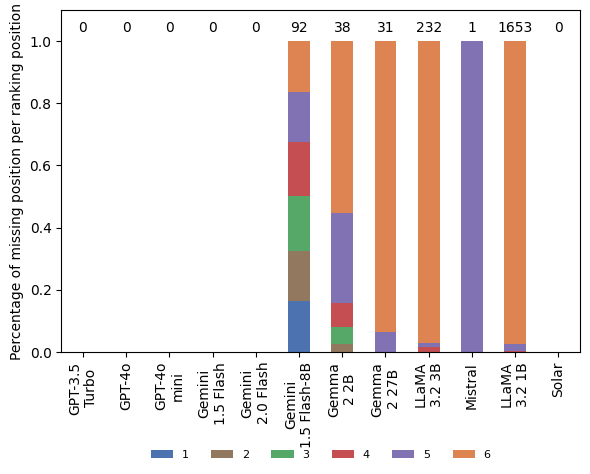

In [25]:
df_missing_abs = pd.DataFrame.from_dict(missing_positions, orient='index')

df_missing_rel = df_missing_abs.div(df_missing_abs.sum(axis=1), axis=0)

ax = df_missing_rel.plot(kind='bar', stacked=True, figsize=(6, 5), color=["#4C72B0", "#937860", "#55A868", "#C44E52",  "#8172B3", "#DD8452"])
plt.ylabel("Percentage of missing position per ranking position")

for i, model in enumerate(df_missing_abs.index):
    total = df_missing_abs.loc[model].sum()
    ax.text(i, 1.02, str(total), ha='center', va='bottom', fontsize=10, color='black')

plt.legend(title="", bbox_to_anchor=(0.5, -0.3), loc='center', ncol=6, fontsize=8, frameon=False,
            markerscale=5)
plt.tight_layout()
ax.set_ylim(0, 1.1)
plt.show()


In [26]:
# Filter out the models with zero missing positions / topics

missing_positions = {}
missing_topics = {}

for model, model_data in results.items():
    if model in ["Gemini 2.0 Flash", "Solar", "Gemini 1.5 Flash", "GPT-4o mini", "GPT-4o", "WizardLM-2"]:
        continue
    
    missing_positions_per_model = defaultdict(int)
    missing_topics_per_model = defaultdict(int)

    metric = "MissingTopics"
    metric_data = model_data[metric]

    df = pd.DataFrame(metric_data)

    for pos in range(1, 7):
        missing_positions_per_model[pos] += np.sum(df[df["position"]==pos]["score"].values)

    # Take one prompt to get all topics
    for pos in df["prompt"][0]:
        missing_topics_per_model[pos] += np.sum(df[df["topic"]==pos]["score"].values)

    model = model.replace(" ", "\n", 1)

    missing_positions[model] = missing_positions_per_model
    missing_topics[model] = missing_topics_per_model

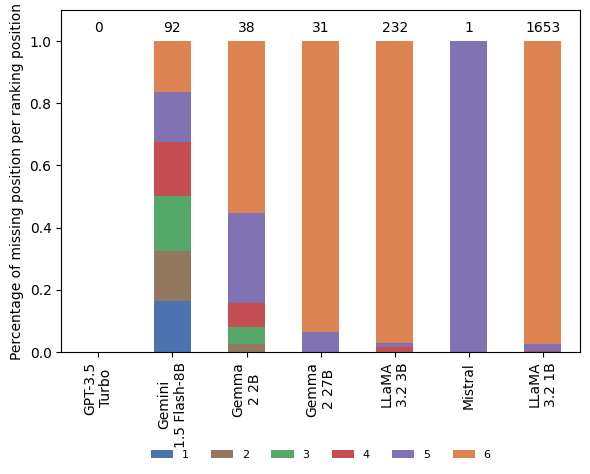

In [27]:
df_missing_abs = pd.DataFrame.from_dict(missing_positions, orient='index')

df_missing_rel = df_missing_abs.div(df_missing_abs.sum(axis=1), axis=0)

ax = df_missing_rel.plot(kind='bar', stacked=True, figsize=(6, 5), color=["#4C72B0", "#937860", "#55A868", "#C44E52",  "#8172B3", "#DD8452"])
plt.ylabel("Percentage of missing position per ranking position")

for i, model in enumerate(df_missing_abs.index):
    total = df_missing_abs.loc[model].sum()
    ax.text(i, 1.02, str(total), ha='center', va='bottom', fontsize=10, color='black')

plt.legend(title="", bbox_to_anchor=(0.5, -0.3), loc='center', ncol=6, fontsize=8, frameon=False,
            markerscale=5)
plt.tight_layout()
ax.set_ylim(0, 1.1)
plt.show()


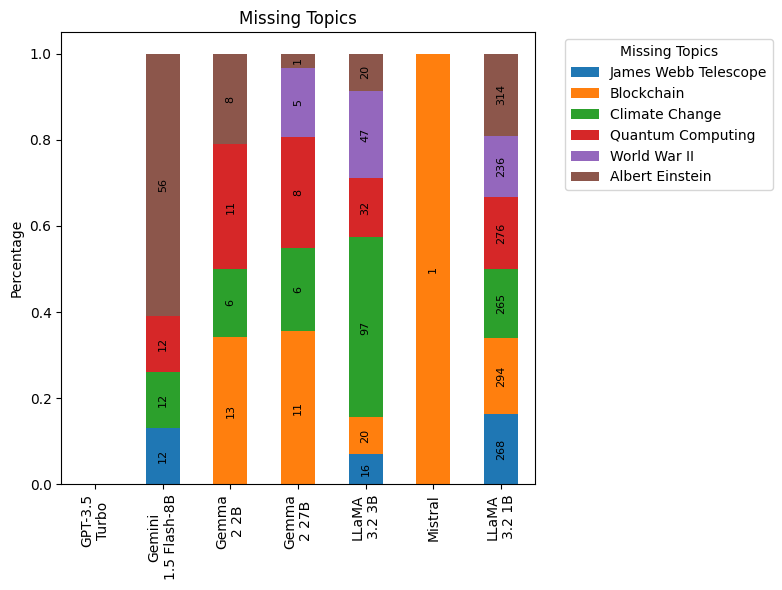

In [28]:
df_missing_abs = pd.DataFrame.from_dict(missing_topics, orient='index')

df_missing_rel = df_missing_abs.div(df_missing_abs.sum(axis=1), axis=0)

ax = df_missing_rel.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.ylabel("Percentage")
plt.title("Missing Topics")

for i, model in enumerate(df_missing_abs.index):
    cumulative = 0 
    for pos in df_missing_abs.columns:
        abs_count = df_missing_abs.loc[model, pos]
        rel_val = df_missing_rel.loc[model, pos]
        
        if abs_count > 0:
            y = cumulative + rel_val / 2
            ax.text(i, y, str(abs_count), ha='center', va='center', fontsize=8, color='black', rotation=90)
        
        cumulative += rel_val

plt.legend(title="Missing Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


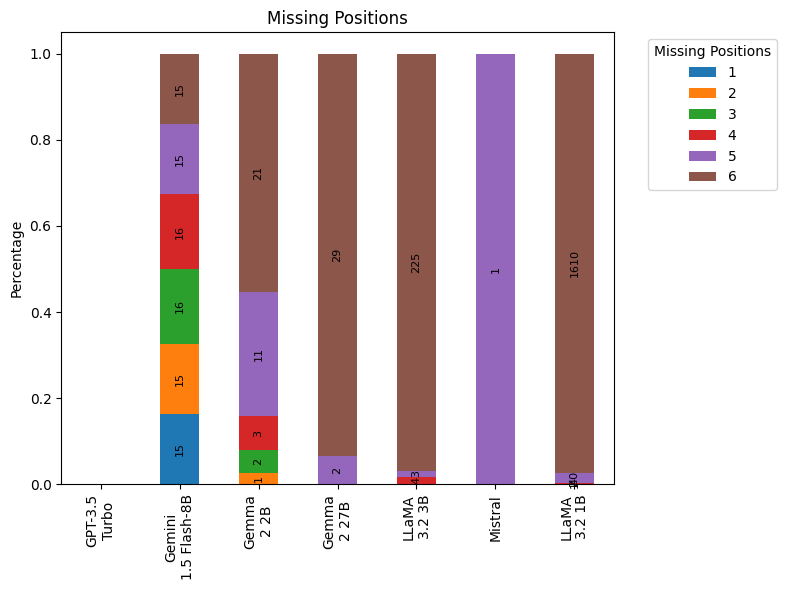

In [29]:
df_missing_abs = pd.DataFrame.from_dict(missing_positions, orient='index')

df_missing_rel = df_missing_abs.div(df_missing_abs.sum(axis=1), axis=0)

ax = df_missing_rel.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.ylabel("Percentage")
plt.title("Missing Positions")


for i, model in enumerate(df_missing_abs.index):
    cumulative = 0 
    for pos in df_missing_abs.columns:
        abs_count = df_missing_abs.loc[model, pos]
        rel_val = df_missing_rel.loc[model, pos]
        
        if abs_count > 0:
            y = cumulative + rel_val / 2
            ax.text(i, y, str(abs_count), ha='center', va='center', fontsize=8, color='black', rotation=90)
        
        cumulative += rel_val

plt.legend(title="Missing Positions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

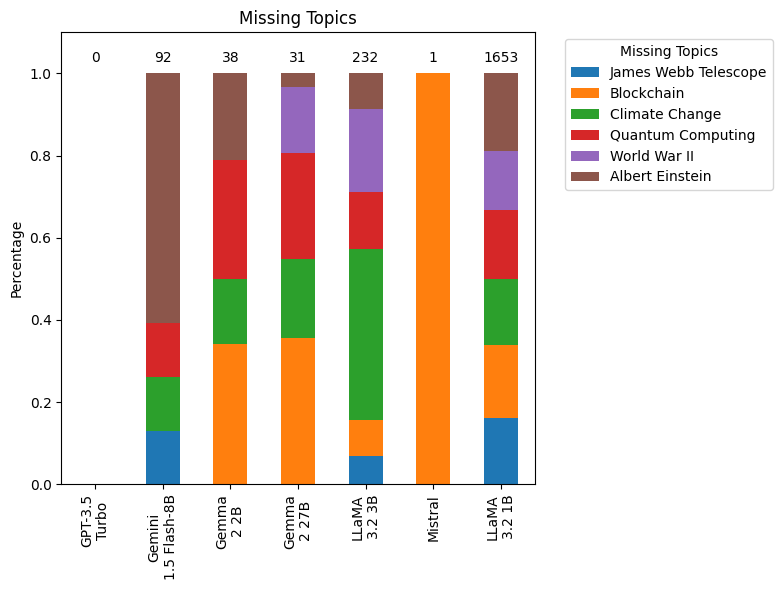

In [30]:
df_missing_abs = pd.DataFrame.from_dict(missing_topics, orient='index')

df_missing_rel = df_missing_abs.div(df_missing_abs.sum(axis=1), axis=0)

ax = df_missing_rel.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.ylabel("Percentage")
plt.title("Missing Topics")

for i, model in enumerate(df_missing_abs.index):
    total = df_missing_abs.loc[model].sum()
    ax.text(i, 1.02, str(total), ha='center', va='bottom', fontsize=10, color='black')

plt.legend(title="Missing Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
ax.set_ylim(0, 1.1)
plt.show()
